In [1]:
import pandas as pd

# Loading dataset
ind_df = pd.read_csv('../data/indigenous_collection_processed.csv', index_col='id')
print(f'Dataframe columns: \n{ind_df.columns}')

Dataframe columns: 
Index(['url', 'thumbnail', 'creation_date', 'modification_date',
       'numero_do_item', 'tripticos', 'categoria', 'nome_do_item',
       'nome_do_item_dic', 'colecao', 'coletor', 'doador', 'modo_de_aquisicao',
       'data_de_aquisicao', 'ano_de_aquisicao', 'data_de_confeccao', 'autoria',
       'nome_etnico', 'descricao', 'dimensoes', 'funcao', 'materia_prima',
       'tecnica_confeccao', 'descritor_tematico', 'descritor_comum',
       'numero_de_pecas', 'itens_relacionados', 'responsavel_guarda',
       'inst_detentora', 'povo', 'autoidentificacao', 'lingua',
       'estado_de_origem', 'geolocalizacao', 'pais_de_origem', 'exposicao',
       'referencias', 'disponibilidade', 'qualificacao', 'historia_adm',
       'notas_gerais', 'observacao', 'conservacao', 'image_path'],
      dtype='object')


In [2]:
import importlib
from IPython.core.magic import register_cell_magic

# Creating skip cell command
@register_cell_magic
def skip(line, cell):
    return

In [3]:
# Centralizing main imports so we can run the models separately
import random
from tqdm.notebook import tqdm
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt

from image_training_utils import *

# import image_training_utils
# importlib.reload(image_training_utils)
# from image_training_utils import *

# Image Clustering

Clustering experiments with image feature extractors. The idea is to fine-tune some pre-trained transformer models on our dataset and then remove the last layer of the model to cluster on the embedding space projections.

## Dataset Preparation

For fine-tuning the model on our dataset, we are going to try a couple different labels (*povo* and *categoria*) and study how they affect the generated emebdding space.

In [4]:
# Filtering out corrupted images
corrupted_images = []
for index, row in ind_df.loc[ind_df['image_path'].notna()].iterrows():
    try:
        Image.open('../'+row['image_path'])
    except Exception as e:
        corrupted_images.append(row['image_path'])
        ind_df.loc[index, 'image_path'] = pd.NA
print(f'{len(corrupted_images)} corrupted images')

# Creating 'image_path_br' column
ind_df['image_path_br'] = ind_df['image_path'].values
ind_df.loc[ind_df['image_path_br'].notna(), 'image_path_br'] = \
    ind_df.loc[ind_df['image_path_br'].notna(), \
               'image_path'].apply(lambda path: \
                                   f"data/br_images/{path.split('/')[-1].split('.')[0]}.png")

1 corrupted images


## ViT Base Patch-16

### Pre-trained Embedding Space

In [5]:
# Getting the proper device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building dataset for column 'povo' (though no specific column is used on off-the-shelf model)
vit_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
povo_labels, povo_name_to_num, povo_num_to_name = preparing_image_labels(ind_df, 'povo')
povo_dataset = ImageDataset(povo_labels, transform=vit_transform, augment=False)

In [6]:
# Projecting data onto the off-the-shelf pre-trained embedding space from ViT
from transformers import ViTModel

# Loading model
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Getting data
povo_dataloader = DataLoader(povo_dataset, batch_size=512, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Computing image embeddings
image_embeddings, _ = get_embeddings(model, povo_dataloader, device)
image_embeddings = np.concatenate(image_embeddings, axis=0)

# Computing data projection
vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [03:05<00:00,  8.07s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Fine-Tuning Embedding Space

In [7]:
# Creating our own ViT classifier (multi-)head for fine-tuning
class ViTClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(ViTClassifier, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.classifier1 = nn.Linear(self.vit.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.vit.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)

    def forward(self, x):
        outputs = self.vit(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.vit.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

In [8]:
# Studying data distribution to filter out rare classes
povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(povo_labels)

# Filtering classes so that we retain around 85% of data
povo_filtered_categories = {}
povo_filtered_categories_names = {}
for c in masks[3][0]:
    povo_filtered_categories[categories_keys[c]] = povo_categories[categories_keys[c]]
    
    povo_filtered_categories_names[povo_num_to_name[categories_keys[c]]] = \
    povo_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 1.00, 99.84% of data
Q-25: 4.00, 99.18% of data
Q-50: 19.00, 95.96% of data
Q-75: 65.75, 83.18% of data
Q-90: 158.20, 63.25% of data



In [9]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            vit_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

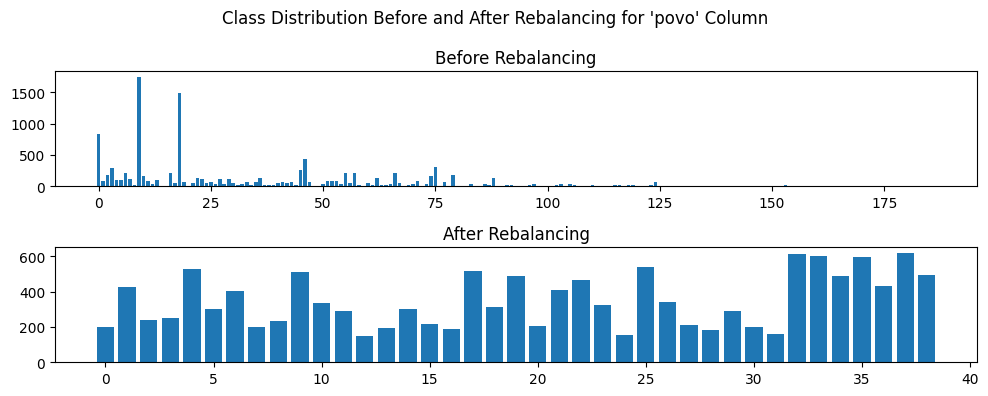

In [10]:
# Plotting old and new class distributions
plot_class_distributions(povo_categories, povo_filtered_categories, labels_minority, \
                         labels_majority, threshold_multiplier, 'povo')

In [11]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
povo_class_weights = compute_class_weights(povo_filtered_categories, labels_minority, \
                                           labels_majority, device, threshold_multiplier)

Training model:   5%|██▎                                          | 1/20 [04:19<1:22:02, 259.10s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1102.2429, Validation Accuracy: 0.3527


Training model:  10%|████▌                                        | 2/20 [08:40<1:18:08, 260.50s/it]

Best model saved at epoch 2
Epoch 2, Loss: 800.2296, Validation Accuracy: 0.4640


Training model:  15%|██████▊                                      | 3/20 [12:59<1:13:33, 259.62s/it]

Best model saved at epoch 3
Epoch 3, Loss: 606.6034, Validation Accuracy: 0.5419


Training model:  20%|█████████                                    | 4/20 [17:14<1:08:44, 257.76s/it]

Best model saved at epoch 4
Epoch 4, Loss: 447.2775, Validation Accuracy: 0.5931


Training model:  25%|███████████▎                                 | 5/20 [21:32<1:04:29, 257.98s/it]

Best model saved at epoch 5
Epoch 5, Loss: 313.7093, Validation Accuracy: 0.6197


Training model:  30%|██████████████                                 | 6/20 [25:46<59:54, 256.76s/it]

Best model saved at epoch 6
Epoch 6, Loss: 213.6696, Validation Accuracy: 0.6414


Training model:  35%|████████████████▍                              | 7/20 [30:01<55:28, 256.03s/it]

Best model saved at epoch 7
Epoch 7, Loss: 140.2860, Validation Accuracy: 0.6571


Training model:  40%|██████████████████▊                            | 8/20 [34:19<51:22, 256.85s/it]

Best model saved at epoch 8
Epoch 8, Loss: 88.4142, Validation Accuracy: 0.6670


Training model:  45%|█████████████████████▏                         | 9/20 [38:36<47:05, 256.90s/it]

Epoch 9, Loss: 57.8860, Validation Accuracy: 0.6650


Training model:  50%|███████████████████████                       | 10/20 [42:54<42:49, 256.97s/it]

Epoch 10, Loss: 39.2355, Validation Accuracy: 0.6621


Training model:  55%|█████████████████████████▎                    | 11/20 [47:08<38:26, 256.30s/it]

Epoch 11, Loss: 31.6019, Validation Accuracy: 0.6502


Training model:  60%|███████████████████████████▌                  | 12/20 [51:15<33:46, 253.37s/it]

Epoch 12, Loss: 58.2557, Validation Accuracy: 0.6236


Training model:  60%|███████████████████████████▌                  | 12/20 [55:27<36:58, 277.26s/it]


Early-stopping training!


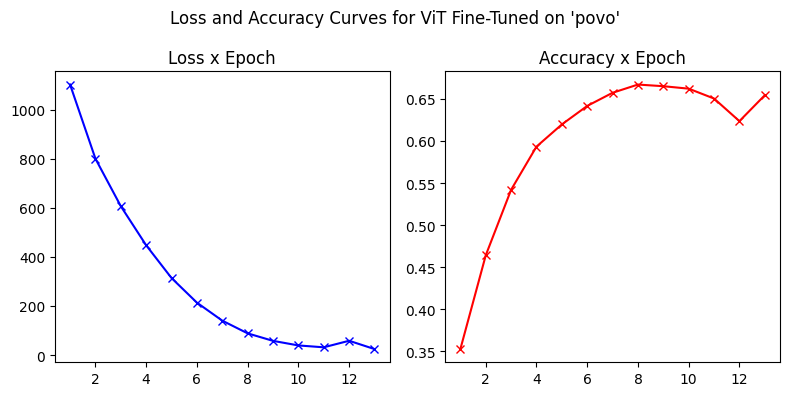

Validation accuracy: 0.6669921875
Validation average per class precision: 0.2289
Validation average per class recall: 0.2340



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:686: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.7080745100975037
Test average per class precision: 0.2717
Test average per class recall: 0.2542

Test average precision on filtered classes: 0.5967337804344984
Test average recall on filtered classes: 0.6666717116649334


In [12]:
# Recreating datasets for proper training and testing
povo_train_val_labels = povo_labels.copy()
povo_test_labels_aux = random.sample(list(povo_train_val_labels), \
                                     int(0.1*len(povo_train_val_labels)))
povo_test_labels = {}
for key in povo_test_labels_aux:
    povo_test_labels[key] = povo_train_val_labels[key]
    del povo_train_val_labels[key]
    
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=vit_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=5e-5, weight_decay=2e-6)
model_name = 'vit_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                         batch_size, epochs, num_classes, model, criterion, \
                                         opt, model_name, column_name)
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [07:02<2:13:47, 422.49s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1393.3742, Validation Accuracy: 0.4022


Training model:  10%|████▌                                        | 2/20 [14:03<2:06:24, 421.34s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1068.0142, Validation Accuracy: 0.5368


Training model:  15%|██████▊                                      | 3/20 [21:17<2:01:06, 427.44s/it]

Best model saved at epoch 3
Epoch 3, Loss: 753.6005, Validation Accuracy: 0.6260


Training model:  20%|█████████                                    | 4/20 [28:12<1:52:38, 422.39s/it]

Best model saved at epoch 4
Epoch 4, Loss: 453.5096, Validation Accuracy: 0.6792


Training model:  25%|███████████▎                                 | 5/20 [35:10<1:45:13, 420.92s/it]

Best model saved at epoch 5
Epoch 5, Loss: 229.6142, Validation Accuracy: 0.6995


Training model:  30%|█████████████▌                               | 6/20 [42:13<1:38:24, 421.73s/it]

Best model saved at epoch 6
Epoch 6, Loss: 109.4760, Validation Accuracy: 0.7042


Training model:  35%|███████████████▋                             | 7/20 [49:12<1:31:10, 420.84s/it]

Epoch 7, Loss: 59.2882, Validation Accuracy: 0.6980


Training model:  40%|██████████████████                           | 8/20 [56:17<1:24:23, 421.95s/it]

Epoch 8, Loss: 36.9356, Validation Accuracy: 0.6980


Training model:  45%|███████████████████▎                       | 9/20 [1:03:24<1:17:39, 423.58s/it]

Epoch 9, Loss: 27.6560, Validation Accuracy: 0.6714


Training model:  50%|█████████████████████                     | 10/20 [1:10:18<1:10:06, 420.63s/it]

Epoch 10, Loss: 26.6857, Validation Accuracy: 0.6823


Training model:  55%|███████████████████████                   | 11/20 [1:17:07<1:02:32, 416.95s/it]

Epoch 11, Loss: 14.9532, Validation Accuracy: 0.6995


Training model:  60%|██████████████████████████▍                 | 12/20 [1:23:48<54:57, 412.19s/it]

Epoch 12, Loss: 10.8364, Validation Accuracy: 0.6980


Training model:  65%|████████████████████████████▌               | 13/20 [1:30:41<48:07, 412.47s/it]

Epoch 13, Loss: 8.3271, Validation Accuracy: 0.6995


Training model:  65%|████████████████████████████▌               | 13/20 [1:37:32<52:31, 450.21s/it]


Early-stopping training!


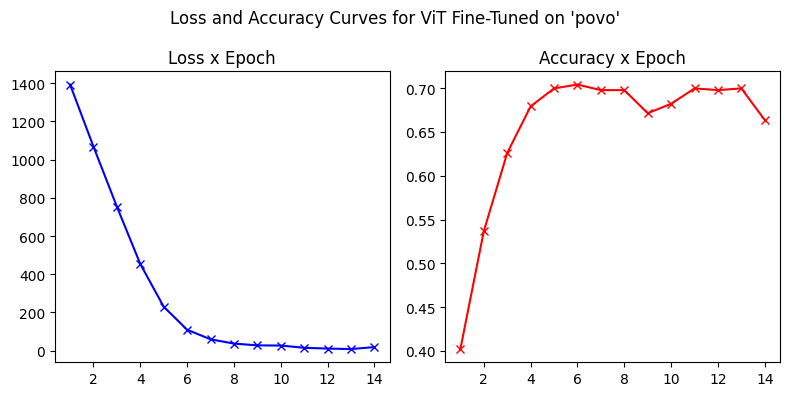

Validation accuracy: 0.7041015625
Validation average per class precision: 0.6850
Validation average per class recall: 0.6458

Test accuracy: 0.684669017791748
Test average per class precision: 0.7012
Test average per class recall: 0.6459



Computing embeddings: 100%|█████████████████████████████████████████| 23/23 [02:54<00:00,  7.61s/it]
/home/lui/anaconda3/envs/ind_thesis/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

povo_vit_trimap, povo_vit_tsne, \
povo_vit_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                  device)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [05:47<1:50:08, 347.79s/it]

Best model saved at epoch 1
Epoch 1, Loss: 1437.3219, Validation Accuracy: 0.3928


Training model:  10%|████▌                                        | 2/20 [11:29<1:43:11, 343.97s/it]

Best model saved at epoch 2
Epoch 2, Loss: 1165.0695, Validation Accuracy: 0.5055


Training model:  15%|██████▊                                      | 3/20 [16:52<1:34:48, 334.62s/it]

Best model saved at epoch 3
Epoch 3, Loss: 904.6800, Validation Accuracy: 0.5853


Training model:  20%|█████████                                    | 4/20 [22:13<1:27:47, 329.19s/it]

Best model saved at epoch 4
Epoch 4, Loss: 638.1844, Validation Accuracy: 0.6479


Training model:  25%|███████████▎                                 | 5/20 [27:35<1:21:37, 326.51s/it]

Best model saved at epoch 5
Epoch 5, Loss: 391.8753, Validation Accuracy: 0.6682


Training model:  30%|█████████████▌                               | 6/20 [32:56<1:15:46, 324.76s/it]

Best model saved at epoch 6
Epoch 6, Loss: 209.3384, Validation Accuracy: 0.7027


Training model:  35%|███████████████▋                             | 7/20 [38:18<1:10:09, 323.84s/it]

Best model saved at epoch 7
Epoch 7, Loss: 108.0149, Validation Accuracy: 0.7042


Training model:  40%|██████████████████                           | 8/20 [43:38<1:04:29, 322.50s/it]

Best model saved at epoch 8
Epoch 8, Loss: 58.1338, Validation Accuracy: 0.7105


Training model:  45%|█████████████████████▏                         | 9/20 [48:58<58:59, 321.78s/it]

Epoch 9, Loss: 36.0385, Validation Accuracy: 0.7074


Training model:  50%|███████████████████████                       | 10/20 [54:20<53:38, 321.89s/it]

Epoch 10, Loss: 22.9774, Validation Accuracy: 0.7089


Training model:  55%|█████████████████████████▎                    | 11/20 [59:42<48:18, 322.05s/it]

Epoch 11, Loss: 16.9329, Validation Accuracy: 0.7089


Training model:  60%|██████████████████████████▍                 | 12/20 [1:05:13<43:16, 324.51s/it]

Epoch 12, Loss: 12.2344, Validation Accuracy: 0.7105


Training model:  65%|████████████████████████████▌               | 13/20 [1:10:53<38:24, 329.26s/it]

Best model saved at epoch 13
Epoch 13, Loss: 8.6472, Validation Accuracy: 0.7121


Training model:  70%|██████████████████████████████▊             | 14/20 [1:16:33<33:16, 332.74s/it]

Epoch 14, Loss: 6.8612, Validation Accuracy: 0.7089


Training model:  75%|█████████████████████████████████           | 15/20 [1:22:00<27:34, 330.89s/it]

Epoch 15, Loss: 6.3940, Validation Accuracy: 0.7042


Training model:  80%|███████████████████████████████████▏        | 16/20 [1:27:26<21:57, 329.35s/it]

Epoch 16, Loss: 4.5568, Validation Accuracy: 0.7058


Training model:  85%|█████████████████████████████████████▍      | 17/20 [1:32:56<16:28, 329.53s/it]

Epoch 17, Loss: 9.6137, Validation Accuracy: 0.6761


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:38:38<11:06, 333.27s/it]

Epoch 18, Loss: 4.3426, Validation Accuracy: 0.6886


Training model:  90%|███████████████████████████████████████▌    | 18/20 [1:44:20<11:35, 347.81s/it]


Early-stopping training!


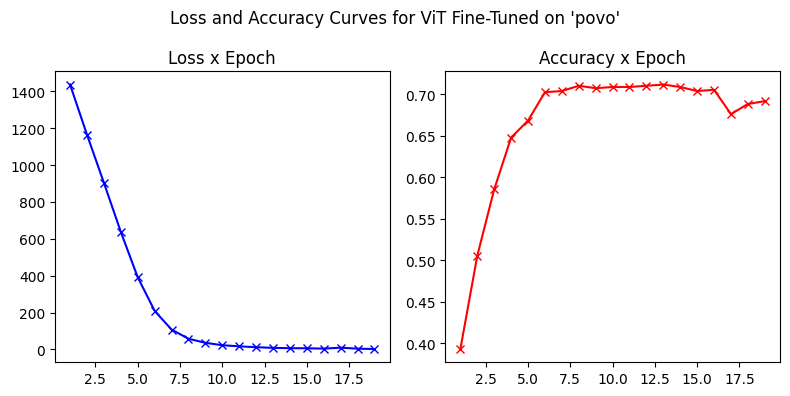

Validation accuracy: 0.7119140625
Validation average per class precision: 0.7020
Validation average per class recall: 0.6567



/home/lui/Documents/uva/thesis/tainacan_collection/image_based/image_training_utils.py:686: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('../data/mo

Test accuracy: 0.6777003407478333
Test average per class precision: 0.6870
Test average per class recall: 0.6343



In [14]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 32
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_vit_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [15]:
# Now rebalancing the 'categoria' column
categoria_labels, categoria_name_to_num, categoria_num_to_name = \
preparing_image_labels(ind_df, 'categoria')
categoria_dataset = ImageDataset(categoria_labels, transform=vit_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=512, shuffle=True, \
                                  num_workers=0, pin_memory=True)

categoria_categories, categories_keys, categories_freq, qs, \
masks = study_class_distribution(categoria_labels)

# Filtering out 'etnobotânica' (and 'armas')
filter_out = [categoria_name_to_num['etnobotânica']]
categoria_filtered_categories = {}
categoria_filtered_categories_names = {}
for c in set(categoria_name_to_num.values()) - set(filter_out):
    categoria_filtered_categories[categories_keys[c]] = \
    categoria_categories[categories_keys[c]]
    
    categoria_filtered_categories_names[categoria_num_to_name[categories_keys[c]]] = \
    categoria_categories[categories_keys[c]]

Quantile X Data Percentage:
Q-10: 216.60, 99.71% of data
Q-25: 507.50, 93.33% of data
Q-50: 1060.50, 79.68% of data
Q-75: 1344.50, 58.09% of data
Q-90: 2270.70, 26.50% of data



In [16]:
# Filtering dataframe for selected categories
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, val_labels, \
test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, vit_transform, \
                               threshold_multiplier, 'categoria')

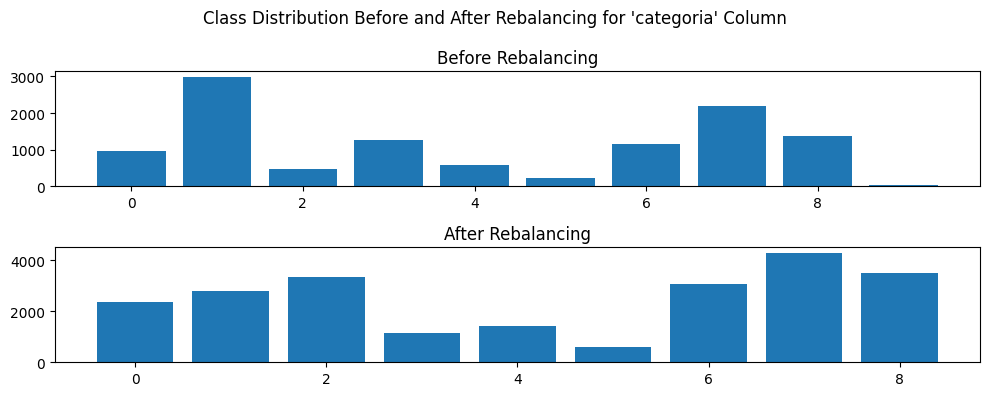

In [17]:
# Plotting old and new class distributions
plot_class_distributions(categoria_categories, categoria_filtered_categories, \
                         labels_minority, labels_majority, threshold_multiplier, 'categoria')

In [18]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
categoria_class_weights = compute_class_weights(categoria_filtered_categories, \
                                                labels_minority, labels_majority, device, \
                                                threshold_multiplier)

In [ ]:
# Recreating datasets for proper training and testing
categoria_train_val_labels = categoria_labels.copy()
categoria_test_labels_aux = random.sample(list(categoria_train_val_labels), \
                                          int(0.1*len(categoria_train_val_labels)))
categoria_test_labels = {}
for key in categoria_test_labels_aux:
    categoria_test_labels[key] = categoria_train_val_labels[key]
    del categoria_train_val_labels[key]
    
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=vit_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, \
                                      transform=vit_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 32
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'vit_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name)
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

Training model:   5%|██▎                                          | 1/20 [04:17<1:21:31, 257.44s/it]

Best model saved at epoch 1
Epoch 1, Loss: 478.9558, Validation Accuracy: 0.6621


Training model:  10%|████▌                                        | 2/20 [08:32<1:16:52, 256.23s/it]

Best model saved at epoch 2
Epoch 2, Loss: 295.4266, Validation Accuracy: 0.7675


Training model:  15%|██████▊                                      | 3/20 [12:49<1:12:35, 256.22s/it]

Best model saved at epoch 3
Epoch 3, Loss: 209.3006, Validation Accuracy: 0.8167


Training model:  20%|█████████                                    | 4/20 [17:03<1:08:05, 255.33s/it]

Best model saved at epoch 4
Epoch 4, Loss: 150.5263, Validation Accuracy: 0.8532


Training model:  25%|███████████▎                                 | 5/20 [21:18<1:03:49, 255.28s/it]

Best model saved at epoch 5
Epoch 5, Loss: 109.8874, Validation Accuracy: 0.8690


Training model:  30%|██████████████                                 | 6/20 [25:31<59:23, 254.55s/it]

Epoch 6, Loss: 78.5949, Validation Accuracy: 0.8670


Training model:  35%|████████████████▍                              | 7/20 [29:44<55:01, 254.00s/it]

Epoch 7, Loss: 58.5078, Validation Accuracy: 0.8670


Training model:  40%|██████████████████▊                            | 8/20 [33:57<50:46, 253.87s/it]

Best model saved at epoch 8
Epoch 8, Loss: 45.2565, Validation Accuracy: 0.8749


Training model:  45%|█████████████████████▏                         | 9/20 [38:12<46:34, 254.04s/it]

Best model saved at epoch 9
Epoch 9, Loss: 36.8748, Validation Accuracy: 0.8837


In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = ViTClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'balanced_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap, \
categoria_image_indices = compute_classifier_embeddings(categoria_dataloader, model, device)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = ViTClassifier(num_classes, freeze=freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'frozen_vit_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset)

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

In [ ]:
# Getting data that passes both heads' data-filters
povo_set = set(np.array(list(povo_labels.keys()))\
                [np.where(np.isin(np.array(list(povo_labels.values())), \
                np.array(list(povo_filtered_categories.keys()))))[0]])
categoria_set = set(np.array(list(categoria_labels.keys()))\
                    [np.where(np.isin(np.array(list(categoria_labels.values())), \
                    np.array(list(categoria_filtered_categories.keys()))))[0]])
multi_head_keys = [str(x) for x in povo_set.intersection(categoria_set)]

# Studying individual and joint classes' distributions
povo_freq = {}
categoria_freq = {}
multi_freq = {}
for key in multi_head_keys:
    try:
        povo_freq[povo_labels[key]] += 1
    except:
        povo_freq[povo_labels[key]] = 1

    try:
        categoria_freq[categoria_labels[key]] += 1
    except:
        categoria_freq[categoria_labels[key]] = 1

    try:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] += 1
    except:
        multi_freq[f'{(povo_labels[key], categoria_labels[key])}'] = 1

# Utility function to plot rows on data distribution plot
def row_bar_plot(col_freq, name, row, rows=3, cols=1, remove_xticks=False):
    plt.subplot(rows, cols, row)
    plt.bar(list(col_freq.keys()), list(col_freq.values()))
    plt.title(name)

    if remove_xticks:
        plt.xlabel("")
        plt.xticks([])

plt.figure(figsize=(10,6))
plt.suptitle('Classes Distributions for Multi-Head Data')

row_bar_plot(povo_freq, "'povo' Column", 1)
row_bar_plot(categoria_freq, "'categoria' Column", 2)
row_bar_plot(multi_freq, "Both Columns (Joint Distribution)", 3, remove_xticks=True)

plt.tight_layout()
plt.show()

In [ ]:
# Because of the even worse degree of unbalanced data on the joint distribution, we balance
# the dataset taking the 'povo' column into consideration and study the new joint distribution
multi_povo_labels = {}
multi_categoria_labels = {}
for key in multi_head_keys:
    multi_povo_labels[key] = povo_labels[key]
    multi_categoria_labels[key] = categoria_labels[key]

# Reusing previous dataset infrastructure to build multi-label dataset
multi_povo_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_povo_labels)
multi_povo_filtered_categories = multi_povo_categories
multi_povo_filtered_categories_names = {}
for c in categories_keys:
    multi_povo_filtered_categories_names[povo_num_to_name[c]] = multi_povo_categories[c]

multi_categoria_categories, categories_keys, categories_freq, \
qs, masks = study_class_distribution(multi_categoria_labels)
multi_categoria_filtered_categories = multi_categoria_categories
multi_categoria_filtered_categories_names = {}
for c in categories_keys:
    multi_categoria_filtered_categories_names[categoria_num_to_name[c]] = \
    multi_categoria_categories[c]

In [ ]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         vit_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

# Plotting old and new class distributions
multihead_plot_class_distributions(multi_povo_categories, multi_povo_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'povo')

multihead_plot_class_distributions(multi_categoria_categories, \
                                   multi_categoria_filtered_categories, \
                                   labels_minority, labels_majority, threshold_multiplier, \
                                   'categoria')

In [ ]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

In [ ]:
# Training multi-head model on balanced dataset to see the difference in results
batch_size = 16
epochs = 30
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = ViTClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=3e-6)
model_name = 'multihead_vit'
column_names = ['povo', 'categoria']
arch_name = 'ViT'
head_weights = [0.5, 0.5]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [ ]:
# Normalizing data for later plot on tool
norm_factor = 12
vanilla_vit_trimap = normalize(vanilla_vit_trimap, norm_factor)
vanilla_vit_tsne = normalize(vanilla_vit_tsne, norm_factor)
vanilla_vit_umap = normalize(vanilla_vit_umap, norm_factor)

povo_vit_trimap = normalize(povo_vit_trimap, norm_factor)
povo_vit_tsne = normalize(povo_vit_tsne, norm_factor)
povo_vit_umap = normalize(povo_vit_umap, norm_factor)

categoria_vit_trimap = normalize(categoria_vit_trimap, norm_factor)
categoria_vit_tsne = normalize(categoria_vit_tsne, norm_factor)
categoria_vit_umap = normalize(categoria_vit_umap, norm_factor)

In [ ]:
# Utility function to plot rows on projection comparison plot
def row_scatter_plot(projs, proj_names, row, color, rows=3, cols=3):
    for i, (proj, proj_name) in enumerate(zip(projs, proj_names)):
        plt.subplot(rows, cols, i+1+(cols*(row-1)))
        plt.scatter(proj[:, 0], proj[:, 1], c=color)
        plt.title(f"{proj_name}")
        plt.xlabel("")
        plt.ylabel("")
        plt.xticks([])
        plt.yticks([])

# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing Projections of ViT Models')

# Plotting vanilla ViT projections
projs = [vanilla_vit_trimap, vanilla_vit_tsne, vanilla_vit_umap]
proj_names = ['Vanilla ViT with TriMap', 'Vanilla ViT with t-SNE', 'Vanilla ViT with UMAP']
row_scatter_plot(projs, proj_names, 1, 'b')

# Plotting ViT fine-tuned on 'povo' projections
projs = [povo_vit_trimap, povo_vit_tsne, povo_vit_umap]
proj_names = ["ViT Fine-Tuned on 'povo' with TriMap", "ViT Fine-Tuned on 'povo' with t-SNE", \
              "ViT Fine-Tuned on 'povo' with UMAP"]
row_scatter_plot(projs, proj_names, 2, 'r')

# Plotting ViT fine-tuned on 'categoria' projections
projs = [categoria_vit_trimap, categoria_vit_tsne, categoria_vit_umap]
proj_names = ["ViT Fine-Tuned on 'categoria' with TriMap", \
              "ViT Fine-Tuned on 'categoria' with t-SNE", \
              "ViT Fine-Tuned on 'categoria' with UMAP"]
row_scatter_plot(projs, proj_names, 3, 'g')

# DECIDE IF I WANT TO PLOT FROZEN AND MULTI-HEAD MODELS' PROJECTIONS DEPENDING ON PERFORMANCE

plt.tight_layout()
plt.show()

### Visualizing Clusters

In [ ]:
# Filtering dataframe to get only the part that contains images
filtered_df = ind_df.loc[ind_df['image_path'].notna()]

# Visualizing 'povo' cluster
visualizing_clusters(filtered_df, povo_vit_umap, povo_image_indices, 'povo', 'UMAP')

In [ ]:
# Visualizing 'categoria' cluster
visualizing_clusters(filtered_df, categoria_vit_umap, categoria_image_indices, \
                     'categoria', 'UMAP')

In [ ]:
# Saving outputs for visualization tool
_ = saving_outputs(filtered_df, povo_labels, povo_vit_umap, povo_image_indices, 'povo', \
                   'povo_vit.csv')

_ = saving_outputs(filtered_df, categoria_labels, categoria_vit_umap, \
                   categoria_image_indices, 'categoria', 'categoria_vit.csv')

## DINOv2

### Pre-Trained Embedding Space

In [ ]:
from transformers import AutoImageProcessor, AutoModel

# Rebuilding dataset with DINO transform and dataloader with smaller batch_size because of 
# the model's size
dino_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
povo_dataset = ImageDataset(povo_labels, transform=dino_transform, augment=False)
povo_dataloader = DataLoader(povo_dataset, batch_size=16, shuffle=True, \
                             num_workers=0, pin_memory=True)

# Loading model and pre-processor
dino_processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')
model.to(device)

# Projecting data onto the off-the-shelf pre-trained embedding space from DINOv2
image_embeddings, _ = get_embeddings(model, povo_dataloader, device, model_name='dino')
image_embeddings = np.concatenate(image_embeddings, axis=0)

# Computing data reduced-dimensionality projections
_, _, vanilla_dino_umap = data_projections(image_embeddings)

# Cleaning up memory
clean_mem([model, image_embeddings])

### Fine-Tuning Embedding Space

In [ ]:
# Creating our own DINO classifier head for fine-tuning
class DINOClassifier(nn.Module):
    def __init__(self, num_classes1, num_classes2=0, freeze=0):
        super(DINOClassifier, self).__init__()
        self.dino = AutoModel.from_pretrained('facebook/dinov2-base')
        self.classifier1 = nn.Linear(self.dino.config.hidden_size, num_classes1)
        self.multi_head = False
        
        # Multi-head architecture
        if num_classes2 > 0:
            self.classifier2 = nn.Linear(self.dino.config.hidden_size, num_classes2)
            self.multi_head = True
        
        self.freeze_layers(freeze)
    
    def forward(self, x):
        outputs = self.dino(x)
        
        # Getting embeddings from last_hidden_state of CLS token (maybe pooler_output?)
        embeddings = outputs['last_hidden_state'][:, 0, :]
        # embeddings = outputs['pooler_output']

        logits1 = self.classifier1(embeddings)
        if self.multi_head:
            logits2 = self.classifier2(embeddings)
            return logits1, logits2
        return logits1

    # Freezing early layers so we don't lose generalization and speed up training
    def freeze_layers(self, freeze):
        if freeze <= 0:
            return

        # Accounting for the embedding freeze
        freeze -= 1
        
        for name, param in self.vit.named_parameters():
            if "embeddings" in name:
                param.requires_grad = False
            elif int(name.split('.')[2]) < freeze:
                param.requires_grad = False
            else:
                break

#### *povo* Column

In [ ]:
# Recreating datasets for proper training and testing
povo_train_val_dataset = ImageDataset(povo_train_val_labels, transform=dino_transform, \
                                      augment=False)
povo_test_dataset = ImageDataset(povo_test_labels, transform=dino_transform, augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['povo'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'dino_povo'
column_name = 'povo'

test_prec, test_rec = execute_train_test(povo_train_val_dataset, povo_test_dataset, device, \
                                        batch_size, epochs, num_classes, model, criterion, \
                                        opt, model_name, column_name, \
                                        architecture_name='DINOv2')
prec_rec_on_selected_classes(povo_categories, povo_filtered_categories, test_prec, test_rec)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, povo_augmented_dataset, povo_balanced_val_dataset, \
povo_balanced_test_dataset = filter_image_data_distribution(ind_df, \
                                                            povo_filtered_categories_names, \
                                                            dino_transform, \
                                                            threshold_multiplier, \
                                                            'povo')

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, batch_size, \
                   epochs, num_classes, model, criterion, opt, model_name, column_name, \
                   povo_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
povo_dino_umap, povo_image_indices = compute_classifier_embeddings(povo_dataloader, model, \
                                                                   device, 'dino')

# Cleaning up memory
clean_mem([model])

In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(povo_filtered_categories)
freeze = 7
model = DINOClassifier(num_classes, freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_dino_povo'
column_name = 'povo'

execute_train_test(povo_augmented_dataset, povo_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, povo_balanced_val_dataset, architecture_name='DINOv2')

# Cleaning up memory
clean_mem([model])

#### *categoria* Column

In [ ]:
# Now creating the 'categoria' dataset
categoria_dataset = ImageDataset(categoria_labels, transform=dino_transform)
categoria_dataloader = DataLoader(categoria_dataset, batch_size=8, shuffle=True, \
                                  num_workers=0, pin_memory=True)

# Recreating datasets for proper training and testing
categoria_train_val_dataset = ImageDataset(categoria_train_val_labels, \
                                           transform=dino_transform, augment=False)
categoria_test_dataset = ImageDataset(categoria_test_labels, transform=dino_transform, \
                                      augment=False)

# Setting-up training, executing training and then running tests
batch_size = 16
epochs = 20
num_classes = ind_df['categoria'].dropna().nunique()
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-5, weight_decay=2e-6)
model_name = 'dino_categoria'
column_name = 'categoria'

test_prec, test_rec = execute_train_test(categoria_train_val_dataset, categoria_test_dataset, \
                                         device, batch_size, epochs, num_classes, model, \
                                         criterion, opt, model_name, column_name, \
                                         architecture_name='DINOv2')
prec_rec_on_selected_classes(categoria_categories, categoria_filtered_categories, test_prec, \
                             test_rec)

# Cleaning up memory
clean_mem([model])

In [ ]:
# Filtering dataframe for selected categories. We need to recompute this part of the dataset
# because of the different transform used
threshold_multiplier = 1.5
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, categoria_augmented_dataset, categoria_balanced_val_dataset, \
categoria_balanced_test_dataset = \
filter_image_data_distribution(ind_df, categoria_filtered_categories_names, dino_transform, \
                               threshold_multiplier, 'categoria')

In [ ]:
# Retraining model with augmented dataset to see the difference in the results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
model = DINOClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=povo_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'balanced_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

_, _, \
categoria_dino_umap, categoria_image_indices = \
compute_classifier_embeddings(categoria_dataloader, model, device, 'dino')

# Cleaning up memory
clean_mem([model])

In [ ]:
# Training partially frozen model on balanced dataset to see the difference in results
batch_size = 16
epochs = 20
num_classes = len(categoria_filtered_categories)
freeze = 7
model = DINOClassifier(num_classes, freeze).to(device)
criterion = nn.CrossEntropyLoss(weight=categoria_class_weights)
opt = optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-6)
model_name = 'frozen_dino_categoria'
column_name = 'categoria'

execute_train_test(categoria_augmented_dataset, categoria_balanced_test_dataset, device, \
                   batch_size, epochs, num_classes, model, criterion, opt, model_name, \
                   column_name, categoria_balanced_val_dataset, architecture_name='DINOv2')

# Cleaning up memory
clean_mem([model])

#### Multi-Head Training

In [ ]:
# Filtering dataframe for selected categories
threshold_multiplier = 2
minority_classes, majority_classes, labels_minority, labels_majority, \
val_labels, test_labels, multi_augmented_dataset, multi_balanced_val_dataset, \
multi_balanced_test_dataset = \
multihead_filter_image_data_distribution(ind_df, [multi_povo_filtered_categories_names, \
                                         multi_categoria_filtered_categories_names], \
                                         dino_transform, threshold_multiplier, \
                                         ['povo', 'categoria'])

In [ ]:
# Because the dataset is still unbalanced, we also create class weights for the loss function
multi_povo_class_weights = multihead_compute_class_weights(multi_povo_filtered_categories, \
                                                           labels_minority, labels_majority, \
                                                           device, threshold_multiplier, \
                                                           'povo')

multi_categoria_class_weights = \
multihead_compute_class_weights(multi_categoria_filtered_categories, labels_minority, \
                                labels_majority, device, threshold_multiplier,'categoria')

In [ ]:
import image_training_utils
importlib.reload(image_training_utils)
from image_training_utils import *

# Training multi-head model on balanced dataset to see the difference in results
batch_size = 8
epochs = 20
num_classes = [len(multi_povo_filtered_categories), len(multi_categoria_filtered_categories)]
model = DINOClassifier(num_classes[0], num_classes[1]).to(device)
criterions = [nn.CrossEntropyLoss(weight=multi_povo_class_weights), \
              nn.CrossEntropyLoss(weight=multi_categoria_class_weights)]
opt = optim.Adam(model.parameters(), lr=3e-6, weight_decay=1e-6)
model_name = 'multihead_dino'
column_names = ['povo', 'categoria']
arch_name = 'DINOv2'
head_weights = [0.5, 0.5]

multihead_execute_train_test(multi_augmented_dataset, multi_balanced_test_dataset, device, \
                             batch_size, epochs, num_classes, model, \
                             criterions, opt, model_name, column_names, \
                             multi_balanced_val_dataset, arch_name, head_weights)

# Cleaning up memory
clean_mem([model])

### Visualizing and Comparing Projections

In [ ]:
# Normalizing data for later plot on tool
vanilla_dino_umap = normalize(vanilla_dino_umap, norm_factor)
povo_dino_umap = normalize(povo_dino_umap, norm_factor)
categoria_dino_umap = normalize(categoria_dino_umap, norm_factor)

In [ ]:
# Visualizing resulting projections
plt.figure(figsize=(12,8))
plt.suptitle('Comparing ViT and DINO Projections')

# Plotting all ViT projections
projs = [vanilla_vit_umap, povo_vit_umap, categoria_vit_umap]
proj_names = ["Vanilla ViT", "'povo' ViT", "'categoria' ViT"]
row_scatter_plot(projs, proj_names, 1, 'b', 2, 3)

# Plotting all DINO projections
projs = [vanilla_dino_umap, povo_dino_umap, categoria_dino_umap]
proj_names = ["Vanilla DINO", "'povo' DINO", "'categoria' DINO"]
row_scatter_plot(projs, proj_names, 2, 'r', 2, 3)

plt.tight_layout()
plt.show()